# COVID XRAY Image Analysis

## Modeling - Neural Networks

### Importing `libraries`

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from joblib import dump, load

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical
import keras

from matplotlib import cm

from sklearn import metrics

import itertools

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPUs available and memory growth set.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPUs available.")

GPUs available and memory growth set.


### Defining `Callbacks`

In [4]:
from tensorflow.keras.callbacks import Callback
from timeit import default_timer as timer

class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

In [19]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor = 'val_loss', 
                               min_delta = 0.01, 
                               patience = 5, 
                               mode = 'min', 
                               verbose = 1)

reduce_learning_rate = ReduceLROnPlateau(monitor = 'val_loss', 
                                         patience = 3, 
                                         factor = 0.1,
                                         min_delta = 0.01,
                                         cooldown = 4, 
                                         verbose = 1)

model_checkpoint = ModelCheckpoint(filepath = '../data/ckpt/checkpoint.model.keras',
                                   monitor = 'val_loss',
                                   mode = 'min',
                                   save_best_only = True)

time_callback = TimingCallback()

### Building `LeNet Model`

In [13]:
inputs = Input(shape = (256, 256, 1))
first_layer = Conv2D(filters = 30, kernel_size = (5, 5), padding = 'valid', activation = 'relu')
second_layer = MaxPooling2D(pool_size = (2, 2))
third_layer = Conv2D(filters = 16, kernel_size = (3, 3), padding = 'valid', activation = 'relu')
fourth_layer = MaxPooling2D(pool_size = (2, 2))
fifth_layer = Dropout(rate = 0.2)
sixth_layer = Flatten()
seventh_layer = Dense(units = 128, activation = 'relu')
eighth_layer = Dense(units = 4, activation = 'softmax')

x = first_layer(inputs)
x = second_layer(x)
x = third_layer(x)
x = fourth_layer(x)
x = fifth_layer(x)
x = sixth_layer(x)
x = seventh_layer(x)
outputs = eighth_layer(x)

model_lenet = Model(inputs, outputs)
model_lenet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 252, 252, 30)   │           780 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 126, 126, 30)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 124, 124, 16)   │         4,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 62, 62, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 62, 62, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 61504)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     7,872,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,878,272 (30.05 MB)

 Trainable params: 7,878,272 (30.05 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# compiling

model_lenet.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

### Loading and preparing `data`

In [6]:
# Load the dataframe
data_lungs_raw = load('../data/data_lungs_raw.joblib')

In [27]:
data_lungs_raw

,0,1,2,3,4,5,6,7,8,9,...,65527,65528,65529,65530,65531,65532,65533,65534,65535,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Normal
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Normal
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Normal
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Normal
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21160,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Viral Pneumonia
21161,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Viral Pneumonia
21162,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Viral Pneumonia
21163,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Viral Pneumonia


In [7]:
X = data_lungs_raw.drop('label', axis = 1)
y = data_lungs_raw.label.replace({'Normal': 0, 'Lung_Opacity': 1, 'Viral Pneumonia': 2, 'COVID': 3})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, shuffle = True)

In [8]:
from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight(class_weight='balanced', classes=data_lungs_raw.label.unique(), y = data_lungs_raw.label)
cw = dict(zip(np.unique(data_lungs_raw.label.replace({'Normal': 0, 'Lung_Opacity': 1, 'Viral Pneumonia': 2, 'COVID': 3})), weights))
print(cw)

{0: 0.5191571821036107, 1: 1.4632881637168142, 2: 0.8801147704590818, 3: 3.934014869888476}


In [9]:
X_train = np.array(X_train).reshape((-1, 256, 256, 1))
X_test = np.array(X_test).reshape((-1, 256, 256, 1))
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [10]:
y_train = np.array(y_train)
y_test = np.array(y_test)

### Model `training`

In [52]:
training_history_lenet = model_lenet.fit(X_train, y_train, epochs = 16, batch_size = 200, validation_split = 0.2,
                                   callbacks = [early_stopping, reduce_learning_rate, model_checkpoint, time_callback],
                                   class_weight = cw, verbose = True)

Epoch 1/16
68/68 ━━━━━━━━━━━━━━━━━━━━ 43s 616ms/step - accuracy: 0.3186 - loss: 1.5436 - val_accuracy: 0.5394 - val_loss: 1.0028 - learning_rate: 0.0010
Epoch 2/16
68/68 ━━━━━━━━━━━━━━━━━━━━ 41s 600ms/step - accuracy: 0.5872 - loss: 1.0671 - val_accuracy: 0.6306 - val_loss: 0.8637 - learning_rate: 0.0010
Epoch 3/16
68/68 ━━━━━━━━━━━━━━━━━━━━ 40s 592ms/step - accuracy: 0.6944 - loss: 0.8484 - val_accuracy: 0.6227 - val_loss: 0.9425 - learning_rate: 0.0010
Epoch 4/16
68/68 ━━━━━━━━━━━━━━━━━━━━ 41s 602ms/step - accuracy: 0.7369 - loss: 0.7352 - val_accuracy: 0.7012 - val_loss: 0.7438 - learning_rate: 0.0010
Epoch 5/16
68/68 ━━━━━━━━━━━━━━━━━━━━ 42s 609ms/step - accuracy: 0.7810 - loss: 0.6062 - val_accuracy: 0.6921 - val_loss: 0.8260 - learning_rate: 0.0010
Epoch 5: early stopping


### Performance Evaluation

In [59]:
train_acc_lenet = training_history_lenet.history['accuracy']
val_acc_lenet = training_history_lenet.history['val_accuracy']

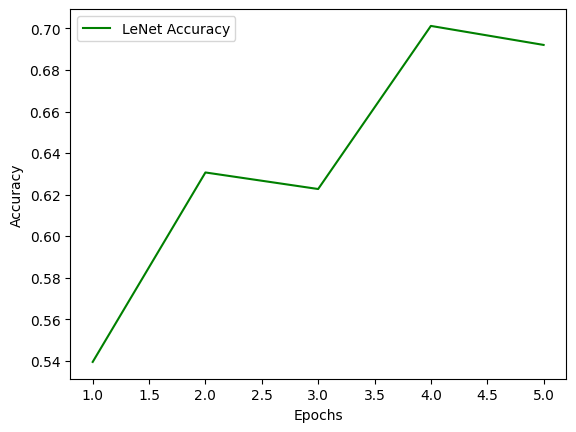

In [62]:
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(np.arange(1, 6, 1),
         val_acc_lenet,
         label = 'LeNet Accuracy',
         color = 'green')

plt.legend()
plt.show()

In [38]:
# removing callback because it stopped training

model_lenet.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
training_history_lenet = model_lenet.fit(X_train, y_train, epochs = 16, batch_size = 200, validation_split = 0.2, class_weight = cw, verbose = True)

Epoch 1/16
68/68 ━━━━━━━━━━━━━━━━━━━━ 46s 644ms/step - accuracy: 0.2943 - loss: 1.6224 - val_accuracy: 0.5441 - val_loss: 0.9929
Epoch 2/16
68/68 ━━━━━━━━━━━━━━━━━━━━ 41s 598ms/step - accuracy: 0.5967 - loss: 1.0880 - val_accuracy: 0.5651 - val_loss: 1.0105
Epoch 3/16
68/68 ━━━━━━━━━━━━━━━━━━━━ 40s 590ms/step - accuracy: 0.6806 - loss: 0.8990 - val_accuracy: 0.6182 - val_loss: 0.8905
Epoch 4/16
68/68 ━━━━━━━━━━━━━━━━━━━━ 42s 609ms/step - accuracy: 0.7254 - loss: 0.7572 - val_accuracy: 0.6466 - val_loss: 0.8748
Epoch 5/16
68/68 ━━━━━━━━━━━━━━━━━━━━ 41s 601ms/step - accuracy: 0.7650 - loss: 0.6524 - val_accuracy: 0.7118 - val_loss: 0.7357
Epoch 6/16
68/68 ━━━━━━━━━━━━━━━━━━━━ 41s 595ms/step - accuracy: 0.8145 - loss: 0.5307 - val_accuracy: 0.6853 - val_loss: 0.8743
Epoch 7/16
68/68 ━━━━━━━━━━━━━━━━━━━━ 41s 595ms/step - accuracy: 0.8444 - loss: 0.4252 - val_accuracy: 0.6631 - val_loss: 0.9560
Epoch 8/16
68/68 ━━━━━━━━━━━━━━━━━━━━ 41s 595ms/step - accuracy: 0.8690 - loss: 0.3414 - val_accu

In [39]:
train_acc_lenet = training_history_lenet.history['accuracy']
val_acc_lenet = training_history_lenet.history['val_accuracy']

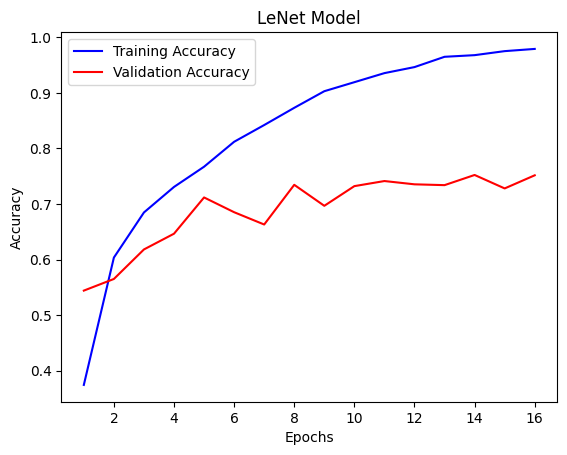

In [40]:
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.plot(np.arange(1, 17, 1),
         train_acc_lenet,
         label = 'Training Accuracy',
         color = 'blue')

plt.plot(np.arange(1, 17, 1),
         val_acc_lenet,
         label = 'Validation Accuracy',
         color = 'red')

plt.title('LeNet Model')
plt.legend()
plt.show()

In [41]:
test_pred_lenet = model_lenet.predict(X_test)
test_pred_class_lenet = test_pred_lenet.argmax(axis = 1)
lenet_accuracy = accuracy_score(y_test, test_pred_class_lenet)
print(lenet_accuracy)
print(metrics.classification_report(y_test, test_pred_class_lenet))

133/133 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step
0.7479329081030003
              precision    recall  f1-score   support

           0       0.81      0.84      0.82      2056
           1       0.72      0.76      0.74      1185
           2       0.87      0.81      0.84       262
           3       0.54      0.45      0.49       730

    accuracy                           0.75      4233
   macro avg       0.74      0.72      0.72      4233
weighted avg       0.74      0.75      0.74      4233



In [42]:
model_lenet.save("../data/ckpt/lenet_model.keras")

In [15]:
training_history_lenet = model_lenet.fit(X_train, y_train, epochs = 25, batch_size = 64, validation_split = 0.2,
                                   callbacks = [early_stopping, reduce_learning_rate],
                                   class_weight = cw, verbose = True)

Epoch 1/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 140s 658ms/step - accuracy: 0.3912 - loss: 1.4488 - val_accuracy: 0.6061 - val_loss: 0.8938 - learning_rate: 0.0010
Epoch 2/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 161s 761ms/step - accuracy: 0.6240 - loss: 1.0089 - val_accuracy: 0.6339 - val_loss: 0.8882 - learning_rate: 0.0010
Epoch 3/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 157s 740ms/step - accuracy: 0.7151 - loss: 0.7985 - val_accuracy: 0.6693 - val_loss: 0.8226 - learning_rate: 0.0010
Epoch 4/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 150s 705ms/step - accuracy: 0.7812 - loss: 0.6101 - val_accuracy: 0.6873 - val_loss: 0.7809 - learning_rate: 0.0010
Epoch 5/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 149s 701ms/step - accuracy: 0.8355 - loss: 0.4468 - val_accuracy: 0.7115 - val_loss: 0.8272 - learning_rate: 0.0010
Epoch 6/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 149s 700ms/step - accuracy: 0.8848 - loss: 0.2928 - val_accuracy: 0.7198 - val_loss: 0.8583 - learning_rate: 0.0010
Epoch 7/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - accuracy

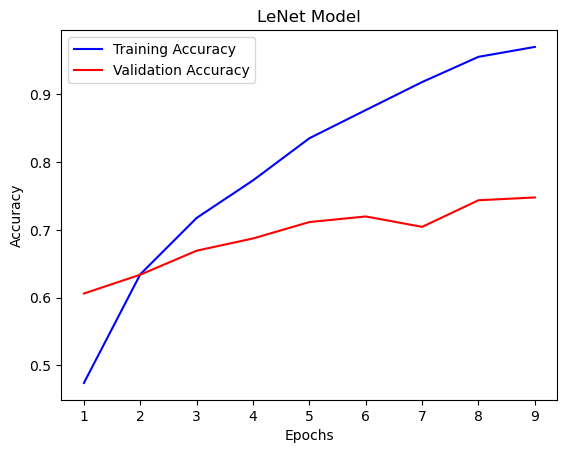

In [17]:
train_acc_lenet = training_history_lenet.history['accuracy']
val_acc_lenet = training_history_lenet.history['val_accuracy']

plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.plot(np.arange(1, 10, 1),
         train_acc_lenet,
         label = 'Training Accuracy',
         color = 'blue')

plt.plot(np.arange(1, 10, 1),
         val_acc_lenet,
         label = 'Validation Accuracy',
         color = 'red')

plt.title('LeNet Model')
plt.legend()
plt.show()

In [18]:
test_pred_lenet = model_lenet.predict(X_test)
test_pred_class_lenet = test_pred_lenet.argmax(axis = 1)
lenet_accuracy = accuracy_score(y_test, test_pred_class_lenet)
print(lenet_accuracy)
print(metrics.classification_report(y_test, test_pred_class_lenet))

133/133 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step
0.7462792345854005
              precision    recall  f1-score   support

           0       0.83      0.81      0.82      2056
           1       0.72      0.75      0.73      1185
           2       0.84      0.81      0.82       262
           3       0.52      0.54      0.53       730

    accuracy                           0.75      4233
   macro avg       0.73      0.73      0.73      4233
weighted avg       0.75      0.75      0.75      4233



### Building another CNN model

In [103]:
img_width = 256
img_height = 256

cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Flatten())
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'softmax', units = 4))

In [18]:
cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 377,796 (1.44 MB)

 Trainable params: 377,796 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

In [104]:
cnn.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [26]:
training_history_cnn = cnn.fit(X_train, y_train, epochs = 16, batch_size = 200, validation_split = 0.2,
                                   callbacks = [early_stopping, reduce_learning_rate, model_checkpoint, time_callback],
                                   class_weight = cw, verbose = True)

Epoch 1/16
68/68 ━━━━━━━━━━━━━━━━━━━━ 47s 670ms/step - accuracy: 0.2145 - loss: 1.6027 - val_accuracy: 0.5884 - val_loss: 0.9888 - learning_rate: 0.0010
Epoch 2/16
68/68 ━━━━━━━━━━━━━━━━━━━━ 43s 618ms/step - accuracy: 0.5786 - loss: 1.1096 - val_accuracy: 0.6891 - val_loss: 0.7351 - learning_rate: 0.0010
Epoch 3/16
68/68 ━━━━━━━━━━━━━━━━━━━━ 42s 612ms/step - accuracy: 0.6696 - loss: 0.9449 - val_accuracy: 0.7039 - val_loss: 0.7327 - learning_rate: 0.0010
Epoch 4/16
68/68 ━━━━━━━━━━━━━━━━━━━━ 42s 621ms/step - accuracy: 0.7003 - loss: 0.8472 - val_accuracy: 0.7207 - val_loss: 0.6659 - learning_rate: 0.0010
Epoch 5/16
68/68 ━━━━━━━━━━━━━━━━━━━━ 43s 628ms/step - accuracy: 0.7378 - loss: 0.7257 - val_accuracy: 0.7384 - val_loss: 0.6658 - learning_rate: 0.0010
Epoch 6/16
68/68 ━━━━━━━━━━━━━━━━━━━━ 42s 611ms/step - accuracy: 0.7580 - loss: 0.7049 - val_accuracy: 0.7969 - val_loss: 0.5333 - learning_rate: 0.0010
Epoch 7/16
68/68 ━━━━━━━━━━━━━━━━━━━━ 43s 629ms/step - accuracy: 0.7805 - loss: 0.

In [27]:
train_acc_cnn = training_history_cnn.history['accuracy']
val_acc_cnn = training_history_cnn.history['val_accuracy']

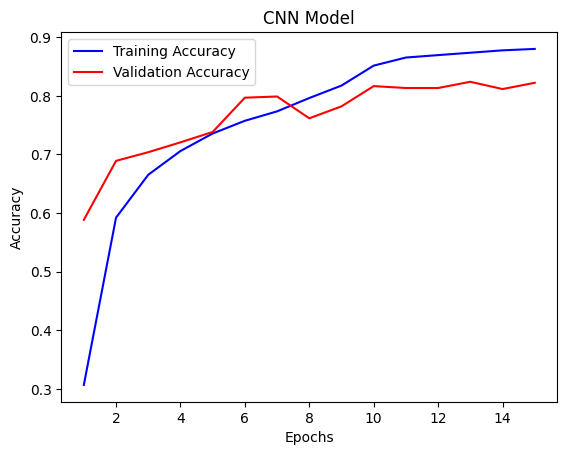

In [29]:
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.plot(np.arange(1, 16, 1),
         train_acc_cnn,
         label = 'Training Accuracy',
         color = 'blue')

plt.plot(np.arange(1, 16, 1),
         val_acc_cnn,
         label = 'Validation Accuracy',
         color = 'red')

plt.title('CNN Model')
plt.legend()
plt.show()

In [32]:
test_pred_cnn = cnn.predict(X_test)
test_pred_class_cnn = test_pred_cnn.argmax(axis = 1)
cnn_accuracy = accuracy_score(y_test, test_pred_class_cnn)
print(cnn_accuracy)
print(metrics.classification_report(y_test, test_pred_class_cnn))

133/133 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step
0.8157335223245925
              precision    recall  f1-score   support

           0       0.92      0.81      0.86      2056
           1       0.82      0.81      0.81      1185
           2       0.90      0.87      0.88       262
           3       0.60      0.81      0.69       730

    accuracy                           0.82      4233
   macro avg       0.81      0.83      0.81      4233
weighted avg       0.83      0.82      0.82      4233



In [35]:
cnn.save("../data/ckpt/cnn_model.keras")


In [43]:
# increase number of epochs for longer learning

In [11]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

early_stopping = EarlyStopping(monitor = 'val_loss', 
                               patience = 5, 
                               mode = 'min', 
                               verbose = 1)

reduce_learning_rate = ReduceLROnPlateau(monitor = 'val_loss', 
                                         patience = 3, 
                                         factor = 0.1,
                                         min_delta = 0.01,
                                         min_lr = 0.000001,
                                         cooldown = 4, 
                                         verbose = 1)

In [48]:
training_history_cnn = cnn.fit(X_train, y_train, epochs = 25, batch_size = 200, validation_split = 0.2,
                                   callbacks = [early_stopping, reduce_learning_rate],
                                   class_weight = cw, verbose = True)

# early stopping max val_acc

Epoch 1/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 48s 680ms/step - accuracy: 0.2535 - loss: 1.5528 - val_accuracy: 0.6779 - val_loss: 0.8023 - learning_rate: 0.0010
Epoch 2/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 44s 650ms/step - accuracy: 0.5817 - loss: 1.0866 - val_accuracy: 0.5719 - val_loss: 1.0364 - learning_rate: 0.0010
Epoch 3/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 43s 637ms/step - accuracy: 0.6524 - loss: 0.9343 - val_accuracy: 0.6932 - val_loss: 0.7555 - learning_rate: 0.0010
Epoch 4/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 42s 619ms/step - accuracy: 0.7028 - loss: 0.8324 - val_accuracy: 0.6915 - val_loss: 0.8127 - learning_rate: 0.0010
Epoch 5/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 42s 608ms/step - accuracy: 0.7181 - loss: 0.7900 - val_accuracy: 0.7422 - val_loss: 0.6393 - learning_rate: 0.0010
Epoch 6/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 43s 626ms/step - accuracy: 0.7465 - loss: 0.7144 - val_accuracy: 0.7638 - val_loss: 0.5946 - learning_rate: 0.0010
Epoch 7/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 42s 614ms/step - accuracy: 0.7478 - loss: 0.

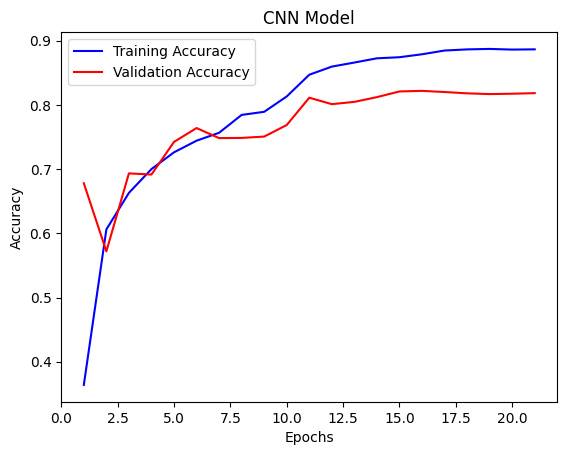

In [51]:
train_acc_cnn = training_history_cnn.history['accuracy']
val_acc_cnn = training_history_cnn.history['val_accuracy']

plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.plot(np.arange(1, 22, 1),
         train_acc_cnn,
         label = 'Training Accuracy',
         color = 'blue')

plt.plot(np.arange(1, 22, 1),
         val_acc_cnn,
         label = 'Validation Accuracy',
         color = 'red')

plt.title('CNN Model')
plt.legend()
plt.show()

In [52]:
test_pred_cnn = cnn.predict(X_test)
test_pred_class_cnn = test_pred_cnn.argmax(axis = 1)
cnn_accuracy = accuracy_score(y_test, test_pred_class_cnn)
print(cnn_accuracy)
print(metrics.classification_report(y_test, test_pred_class_cnn))

133/133 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step
0.8240018899125915
              precision    recall  f1-score   support

           0       0.91      0.83      0.87      2056
           1       0.82      0.82      0.82      1185
           2       0.92      0.89      0.91       262
           3       0.63      0.79      0.70       730

    accuracy                           0.82      4233
   macro avg       0.82      0.83      0.82      4233
weighted avg       0.84      0.82      0.83      4233



In [56]:
# decreasing batch:size to 64

training_history_cnn = cnn.fit(X_train, y_train, epochs = 25, batch_size = 64, validation_split = 0.2,
                                   callbacks = [early_stopping, reduce_learning_rate],
                                   class_weight = cw, verbose = True)

Epoch 1/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 47s 211ms/step - accuracy: 0.2907 - loss: 1.5055 - val_accuracy: 0.6705 - val_loss: 0.8094 - learning_rate: 0.0010
Epoch 2/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 43s 202ms/step - accuracy: 0.6083 - loss: 1.0312 - val_accuracy: 0.6002 - val_loss: 0.9526 - learning_rate: 0.0010
Epoch 3/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 44s 205ms/step - accuracy: 0.6898 - loss: 0.8508 - val_accuracy: 0.6823 - val_loss: 0.7518 - learning_rate: 0.0010
Epoch 4/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 43s 202ms/step - accuracy: 0.7361 - loss: 0.7446 - val_accuracy: 0.7555 - val_loss: 0.6134 - learning_rate: 0.0010
Epoch 5/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 43s 202ms/step - accuracy: 0.7599 - loss: 0.6646 - val_accuracy: 0.7824 - val_loss: 0.5569 - learning_rate: 0.0010
Epoch 5: early stopping


In [62]:
training_history_cnn = cnn.fit(X_train, y_train, epochs = 25, batch_size = 64, validation_split = 0.2,
                                   callbacks = [early_stopping, reduce_learning_rate],
                                   class_weight = cw, verbose = True)

# early stopping min val_loss

Epoch 1/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 48s 212ms/step - accuracy: 0.3169 - loss: 1.4346 - val_accuracy: 0.7115 - val_loss: 0.7273 - learning_rate: 0.0010
Epoch 2/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 43s 202ms/step - accuracy: 0.6677 - loss: 0.9417 - val_accuracy: 0.7422 - val_loss: 0.6295 - learning_rate: 0.0010
Epoch 3/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 44s 205ms/step - accuracy: 0.7143 - loss: 0.8088 - val_accuracy: 0.7012 - val_loss: 0.7315 - learning_rate: 0.0010
Epoch 4/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 44s 206ms/step - accuracy: 0.7429 - loss: 0.7173 - val_accuracy: 0.7535 - val_loss: 0.6069 - learning_rate: 0.0010
Epoch 5/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 45s 213ms/step - accuracy: 0.7610 - loss: 0.6534 - val_accuracy: 0.7301 - val_loss: 0.6826 - learning_rate: 0.0010
Epoch 6/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 45s 211ms/step - accuracy: 0.7902 - loss: 0.5593 - val_accuracy: 0.8034 - val_loss: 0.5093 - learning_rate: 0.0010
Epoch 7/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 45s 211ms/step - accuracy: 0.8

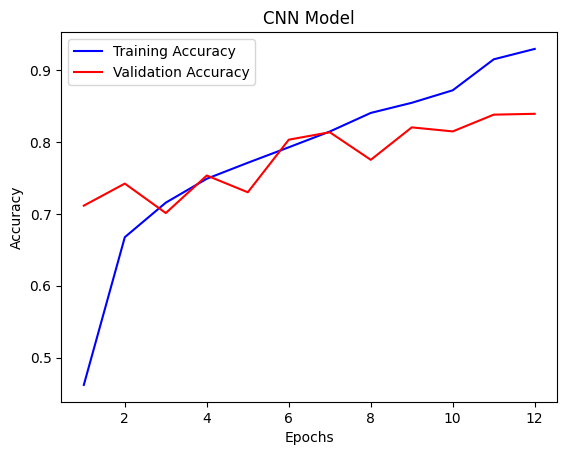

In [64]:
train_acc_cnn = training_history_cnn.history['accuracy']
val_acc_cnn = training_history_cnn.history['val_accuracy']

plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.plot(np.arange(1, 13, 1),
         train_acc_cnn,
         label = 'Training Accuracy',
         color = 'blue')

plt.plot(np.arange(1, 13, 1),
         val_acc_cnn,
         label = 'Validation Accuracy',
         color = 'red')

plt.title('CNN Model')
plt.legend()
plt.show()

In [65]:
test_pred_cnn = cnn.predict(X_test)
test_pred_class_cnn = test_pred_cnn.argmax(axis = 1)
cnn_accuracy = accuracy_score(y_test, test_pred_class_cnn)
print(cnn_accuracy)
print(metrics.classification_report(y_test, test_pred_class_cnn))

133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step
0.8367587999055044
              precision    recall  f1-score   support

           0       0.91      0.85      0.88      2056
           1       0.80      0.83      0.82      1185
           2       0.91      0.89      0.90       262
           3       0.69      0.79      0.74       730

    accuracy                           0.84      4233
   macro avg       0.83      0.84      0.83      4233
weighted avg       0.84      0.84      0.84      4233



In [45]:
training_history_cnn = cnn.fit(X_train, y_train, epochs = 25, batch_size = 64, validation_split = 0.2,
                                   callbacks = [early_stopping, reduce_learning_rate],
                                   class_weight = cw, verbose = True)

# early stopping min val_loss, cpu

Epoch 1/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 121s 566ms/step - accuracy: 0.3457 - loss: 1.4300 - val_accuracy: 0.5979 - val_loss: 0.9175 - learning_rate: 0.0010
Epoch 2/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 118s 557ms/step - accuracy: 0.6516 - loss: 0.9495 - val_accuracy: 0.7375 - val_loss: 0.6428 - learning_rate: 0.0010
Epoch 3/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 117s 553ms/step - accuracy: 0.7177 - loss: 0.7757 - val_accuracy: 0.6537 - val_loss: 0.8339 - learning_rate: 0.0010
Epoch 4/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 118s 556ms/step - accuracy: 0.7345 - loss: 0.7168 - val_accuracy: 0.7065 - val_loss: 0.7046 - learning_rate: 0.0010
Epoch 5/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.7729 - loss: 0.6358
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
212/212 ━━━━━━━━━━━━━━━━━━━━ 118s 555ms/step - accuracy: 0.7729 - loss: 0.6358 - val_accuracy: 0.7399 - val_loss: 0.6567 - learning_rate: 0.0010
Epoch 6/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 118s 554ms/step - accuracy

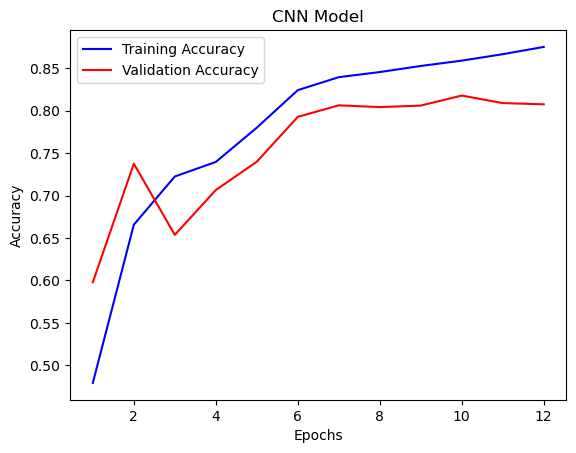

In [46]:
train_acc_cnn = training_history_cnn.history['accuracy']
val_acc_cnn = training_history_cnn.history['val_accuracy']

plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.plot(np.arange(1, 13, 1),
         train_acc_cnn,
         label = 'Training Accuracy',
         color = 'blue')

plt.plot(np.arange(1, 13, 1),
         val_acc_cnn,
         label = 'Validation Accuracy',
         color = 'red')

plt.title('CNN Model')
plt.legend()
plt.show()

In [47]:
test_pred_cnn = cnn.predict(X_test)
test_pred_class_cnn = test_pred_cnn.argmax(axis = 1)
cnn_accuracy = accuracy_score(y_test, test_pred_class_cnn)
print(cnn_accuracy)
print(metrics.classification_report(y_test, test_pred_class_cnn))

133/133 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step
0.8147885660288212
              precision    recall  f1-score   support

           0       0.93      0.79      0.86      2056
           1       0.81      0.82      0.81      1185
           2       0.91      0.88      0.90       262
           3       0.60      0.84      0.70       730

    accuracy                           0.81      4233
   macro avg       0.81      0.83      0.82      4233
weighted avg       0.84      0.81      0.82      4233



### Applying ``ImageDataGenerator``

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
test_datagen = ImageDataGenerator()

In [49]:
train_dataset = train_datagen.flow(X_train, y_train, batch_size = 128)

test_dataset = test_datagen.flow(X_test, y_test, batch_size = 128) 

In [88]:
batch_size = 128
training_history_cnn = cnn.fit(train_dataset, validation_data = test_dataset, epochs = 25, 
                                    steps_per_epoch = X_train.shape[0] // batch_size,
                                    callbacks = [early_stopping, reduce_learning_rate],
                                    class_weight = cw,
                                    verbose = True)

Epoch 1/25


/Users/philipptrinh/anaconda3/envs/tf-metal/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


132/132 ━━━━━━━━━━━━━━━━━━━━ 213s 2s/step - accuracy: 0.2541 - loss: 1.5292 - val_accuracy: 0.5738 - val_loss: 0.9716 - learning_rate: 0.0010
Epoch 2/25
  1/132 ━━━━━━━━━━━━━━━━━━━━ 37s 285ms/step - accuracy: 0.4444 - loss: 0.9731

2024-07-14 11:36:17.063402: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-14 11:36:17.063431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_44]]
2024-07-14 11:36:17.063442: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3102492088187933144
2024-07-14 11:36:17.063454: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6997652386577638113
2024-07-14 11:36:17.063470: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9056436252259226844
2024-07-14 11:36:17.063481: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124803250900808

132/132 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.4444 - loss: 0.9731 - val_accuracy: 0.5972 - val_loss: 0.9211 - learning_rate: 0.0010
Epoch 3/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 214s 2s/step - accuracy: 0.5645 - loss: 1.1238 - val_accuracy: 0.6799 - val_loss: 0.7451 - learning_rate: 0.0010
Epoch 4/25
  1/132 ━━━━━━━━━━━━━━━━━━━━ 57s 443ms/step - accuracy: 0.6016 - loss: 0.9703

2024-07-14 11:39:56.983891: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-14 11:39:56.983917: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_18/_64]]
2024-07-14 11:39:56.983949: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11659035273140208084
2024-07-14 11:39:56.983963: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7155974065080067064
2024-07-14 11:39:56.983971: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6337380317621749524
2024-07-14 11:39:56.983981: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 414229521

132/132 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.6016 - loss: 0.9703 - val_accuracy: 0.6896 - val_loss: 0.7442 - learning_rate: 0.0010
Epoch 5/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.6349 - loss: 0.9777 - val_accuracy: 0.6541 - val_loss: 0.7945 - learning_rate: 0.0010
Epoch 5: early stopping


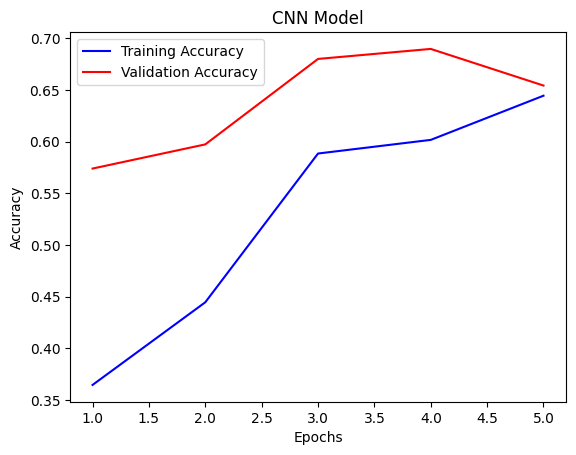

In [89]:
train_acc_cnn = training_history_cnn.history['accuracy']
val_acc_cnn = training_history_cnn.history['val_accuracy']

plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.plot(np.arange(1, 6, 1),
         train_acc_cnn,
         label = 'Training Accuracy',
         color = 'blue')

plt.plot(np.arange(1, 6, 1),
         val_acc_cnn,
         label = 'Validation Accuracy',
         color = 'red')

plt.title('CNN Model')
plt.legend()
plt.show()

In [90]:
test_pred_cnn = cnn.predict(X_test)
test_pred_class_cnn = test_pred_cnn.argmax(axis = 1)
cnn_accuracy = accuracy_score(y_test, test_pred_class_cnn)
print(cnn_accuracy)
print(metrics.classification_report(y_test, test_pred_class_cnn))

133/133 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step
0.6541459957476967
              precision    recall  f1-score   support

           0       0.94      0.54      0.68      2056
           1       0.79      0.74      0.76      1185
           2       0.88      0.76      0.81       262
           3       0.34      0.81      0.48       730

    accuracy                           0.65      4233
   macro avg       0.74      0.71      0.69      4233
weighted avg       0.79      0.65      0.68      4233



In [94]:
# decreasing batch_size from 128 to 64

train_dataset = train_datagen.flow(X_train, y_train, batch_size = 64)

test_dataset = test_datagen.flow(X_test, y_test, batch_size = 64)

batch_size = 64
training_history_cnn = cnn.fit(train_dataset, validation_data = test_dataset, epochs = 25, 
                                    steps_per_epoch = X_train.shape[0] // batch_size,
                                    callbacks = [early_stopping, reduce_learning_rate],
                                    class_weight = cw,
                                    verbose = True)

Epoch 1/25


/Users/philipptrinh/anaconda3/envs/tf-metal/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


264/264 ━━━━━━━━━━━━━━━━━━━━ 164s 612ms/step - accuracy: 0.2824 - loss: 1.5012 - val_accuracy: 0.5608 - val_loss: 0.9891 - learning_rate: 0.0010
Epoch 2/25
  1/264 ━━━━━━━━━━━━━━━━━━━━ 1:11 272ms/step - accuracy: 0.5938 - loss: 0.8841

2024-07-14 11:46:46.768633: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-14 11:46:46.768662: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11659035273140208084
2024-07-14 11:46:46.768686: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/ArgMax/_86]]
2024-07-14 11:46:46.768708: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6337380317621749524
2024-07-14 11:46:46.768720: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124803250900808223
2024-07-14 11:46:46.768723: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11300610403138

264/264 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.5938 - loss: 0.8841 - val_accuracy: 0.5273 - val_loss: 1.0349 - learning_rate: 0.0010
Epoch 3/25
264/264 ━━━━━━━━━━━━━━━━━━━━ 223s 841ms/step - accuracy: 0.6067 - loss: 1.0491 - val_accuracy: 0.6022 - val_loss: 0.8200 - learning_rate: 0.0010
Epoch 4/25
  1/264 ━━━━━━━━━━━━━━━━━━━━ 53s 204ms/step - accuracy: 0.5469 - loss: 1.3213

2024-07-14 11:50:35.983958: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-14 11:50:35.983984: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11970027232302415848
2024-07-14 11:50:35.983989: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3102492088187933144
2024-07-14 11:50:35.983999: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4701583028494916320
2024-07-14 11:50:35.984005: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-14 11:50:35.984023: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15156485700129732472
2024-07-1

264/264 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.5469 - loss: 1.3213 - val_accuracy: 0.6400 - val_loss: 0.7555 - learning_rate: 0.0010
Epoch 5/25
264/264 ━━━━━━━━━━━━━━━━━━━━ 249s 939ms/step - accuracy: 0.6657 - loss: 0.9383 - val_accuracy: 0.6456 - val_loss: 0.7998 - learning_rate: 0.0010
Epoch 5: early stopping


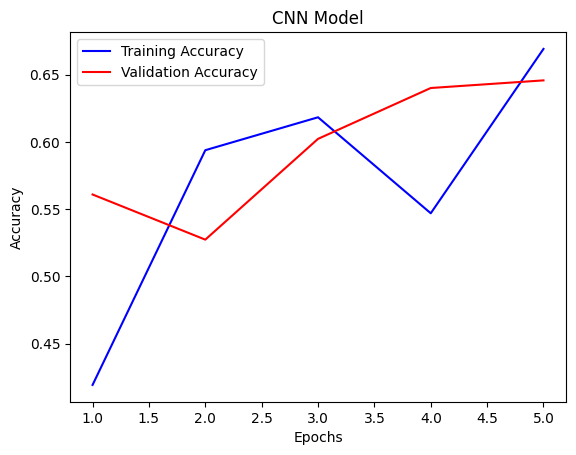

In [95]:
train_acc_cnn = training_history_cnn.history['accuracy']
val_acc_cnn = training_history_cnn.history['val_accuracy']

plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.plot(np.arange(1, 6, 1),
         train_acc_cnn,
         label = 'Training Accuracy',
         color = 'blue')

plt.plot(np.arange(1, 6, 1),
         val_acc_cnn,
         label = 'Validation Accuracy',
         color = 'red')

plt.title('CNN Model')
plt.legend()
plt.show()

In [96]:
test_pred_cnn = cnn.predict(X_test)
test_pred_class_cnn = test_pred_cnn.argmax(axis = 1)
cnn_accuracy = accuracy_score(y_test, test_pred_class_cnn)
print(cnn_accuracy)
print(metrics.classification_report(y_test, test_pred_class_cnn))

133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step
0.6456413890857547
              precision    recall  f1-score   support

           0       0.92      0.64      0.75      2056
           1       0.92      0.44      0.60      1185
           2       0.89      0.81      0.85       262
           3       0.34      0.93      0.50       730

    accuracy                           0.65      4233
   macro avg       0.77      0.70      0.67      4233
weighted avg       0.82      0.65      0.67      4233



In [ ]:
train_dataset = train_datagen.flow(X_train, y_train, batch_size = 32)

test_dataset = test_datagen.flow(X_test, y_test, batch_size = 32)

# # Define a generator function
# def generator():
#     for batch in train_dataset:
#         yield batch

# # Convert the generator to a tf.data.Dataset
# dataset = tf.data.Dataset.from_generator(
#     generator,
#     output_signature=(
#         tf.TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32),
#         tf.TensorSpec(shape=(None, 1), dtype=tf.int32)
#     )
# )

# # Shuffle, batch, and prefetch the dataset
# dataset = dataset.shuffle(buffer_size=1000).batch(64).prefetch(buffer_size=tf.data.AUTOTUNE)
    
training_history_cnn = cnn.fit(dataset, epochs = 25, 
                                    steps_per_epoch = len(X_train) // 64,
                                    callbacks = [early_stopping, reduce_learning_rate],
                                    class_weight = cw,
                                    verbose = True)

# cpu

In [105]:
train_dataset = train_datagen.flow(X_train, y_train, batch_size = 32)

test_dataset = test_datagen.flow(X_test, y_test, batch_size = 32)

batch_size = 32
training_history_cnn = cnn.fit(train_dataset, validation_data = test_dataset, epochs = 25, 
                                    callbacks = [early_stopping, reduce_learning_rate],
                                    class_weight = cw,
                                    verbose = True)

Epoch 1/25
530/530 ━━━━━━━━━━━━━━━━━━━━ 451s 847ms/step - accuracy: 0.3778 - loss: 1.3965 - val_accuracy: 0.5918 - val_loss: 0.9119 - learning_rate: 0.0010
Epoch 2/25
530/530 ━━━━━━━━━━━━━━━━━━━━ 580s 1s/step - accuracy: 0.6106 - loss: 1.0246 - val_accuracy: 0.7153 - val_loss: 0.6346 - learning_rate: 0.0010
Epoch 3/25
530/530 ━━━━━━━━━━━━━━━━━━━━ 758s 1s/step - accuracy: 0.6781 - loss: 0.8823 - val_accuracy: 0.7501 - val_loss: 0.5799 - learning_rate: 0.0010
Epoch 4/25
530/530 ━━━━━━━━━━━━━━━━━━━━ 685s 1s/step - accuracy: 0.6987 - loss: 0.8227 - val_accuracy: 0.7087 - val_loss: 0.6561 - learning_rate: 0.0010
Epoch 5/25
530/530 ━━━━━━━━━━━━━━━━━━━━ 801s 2s/step - accuracy: 0.7193 - loss: 0.7698 - val_accuracy: 0.6712 - val_loss: 0.7607 - learning_rate: 0.0010
Epoch 6/25
530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7262 - loss: 0.7583
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
530/530 ━━━━━━━━━━━━━━━━━━━━ 895s 2s/step - accuracy: 0.7262 - loss: 0

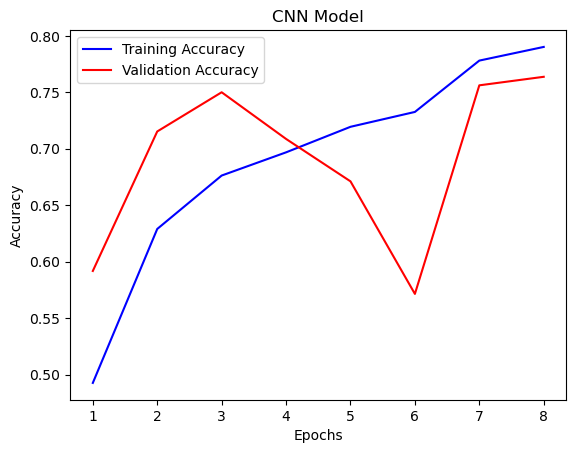

In [106]:
train_acc_cnn = training_history_cnn.history['accuracy']
val_acc_cnn = training_history_cnn.history['val_accuracy']

plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.plot(np.arange(1, 9, 1),
         train_acc_cnn,
         label = 'Training Accuracy',
         color = 'blue')

plt.plot(np.arange(1, 9, 1),
         val_acc_cnn,
         label = 'Validation Accuracy',
         color = 'red')

plt.title('CNN Model')
plt.legend()
plt.show()

In [107]:
test_pred_cnn = cnn.predict(X_test)
test_pred_class_cnn = test_pred_cnn.argmax(axis = 1)
cnn_accuracy = accuracy_score(y_test, test_pred_class_cnn)
print(cnn_accuracy)
print(metrics.classification_report(y_test, test_pred_class_cnn))

133/133 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step
0.7637609260571698
              precision    recall  f1-score   support

           0       0.95      0.73      0.82      2056
           1       0.85      0.71      0.77      1185
           2       0.96      0.83      0.89       262
           3       0.47      0.93      0.63       730

    accuracy                           0.76      4233
   macro avg       0.81      0.80      0.78      4233
weighted avg       0.84      0.76      0.78      4233



### Training with whole images

In [3]:
# Load the dataframe
data_all = load('../data/data_all.joblib')

In [4]:
X = data_all.drop('label', axis = 1)
y = data_all.label.replace({'Normal': 0, 'Lung Opacity': 1, 'Pneumonia': 2, 'COVID': 3})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, shuffle = True)

In [5]:
from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight(class_weight='balanced', classes=data_all.label.unique(), y = data_all.label)
cw = dict(zip(np.unique(data_all.label.replace({'Normal': 0, 'Lung Opacity': 1, 'Pneumonia': 2, 'COVID': 3})), weights))
print(cw)

{0: 0.5191571821036107, 1: 0.8801147704590818, 2: 3.934014869888476, 3: 1.4632881637168142}


In [6]:
X_train = np.array(X_train).reshape((-1, 299, 299, 1))
X_test = np.array(X_test).reshape((-1, 299, 299, 1))
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [7]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [8]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

early_stopping = EarlyStopping(monitor = 'val_loss', 
                               patience = 5, 
                               mode = 'min', 
                               verbose = 1)

reduce_learning_rate = ReduceLROnPlateau(monitor = 'val_loss', 
                                         patience = 3, 
                                         factor = 0.1,
                                         min_lr = 0.000001,
                                         cooldown = 4, 
                                         verbose = 1)

In [30]:
img_width = 299
img_height = 299

cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Flatten())
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'softmax', units = 4))

/Users/philipptrinh/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [31]:
cnn.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [32]:
training_history_cnn = cnn.fit(X_train, y_train, epochs = 25, batch_size = 64, validation_split = 0.2,
                               callbacks = [early_stopping, reduce_learning_rate],
                               class_weight = cw, verbose = True)

Epoch 1/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 185s 868ms/step - accuracy: 0.5062 - loss: 1.0787 - val_accuracy: 0.7470 - val_loss: 0.6321 - learning_rate: 0.0010
Epoch 2/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 182s 859ms/step - accuracy: 0.7386 - loss: 0.5331 - val_accuracy: 0.8093 - val_loss: 0.5047 - learning_rate: 0.0010
Epoch 3/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 190s 896ms/step - accuracy: 0.7987 - loss: 0.4183 - val_accuracy: 0.8249 - val_loss: 0.4577 - learning_rate: 0.0010
Epoch 4/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 194s 913ms/step - accuracy: 0.8381 - loss: 0.3390 - val_accuracy: 0.8403 - val_loss: 0.4230 - learning_rate: 0.0010
Epoch 5/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 187s 883ms/step - accuracy: 0.8536 - loss: 0.3100 - val_accuracy: 0.8636 - val_loss: 0.3759 - learning_rate: 0.0010
Epoch 6/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 190s 896ms/step - accuracy: 0.8733 - loss: 0.2651 - val_accuracy: 0.8671 - val_loss: 0.3595 - learning_rate: 0.0010
Epoch 7/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 189s 890ms/step - accura

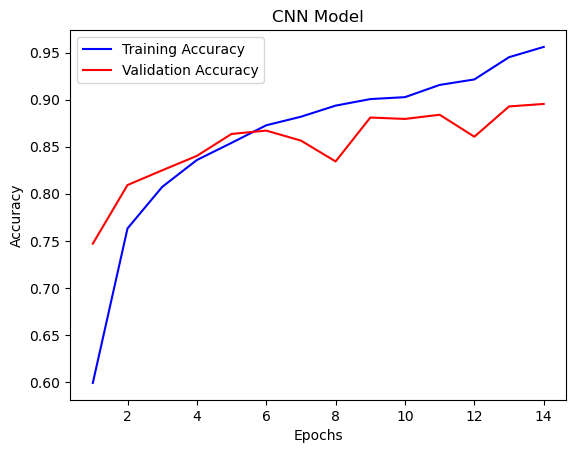

In [34]:
train_acc_cnn = training_history_cnn.history['accuracy']
val_acc_cnn = training_history_cnn.history['val_accuracy']

plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.plot(np.arange(1, 15, 1),
         train_acc_cnn,
         label = 'Training Accuracy',
         color = 'blue')

plt.plot(np.arange(1, 15, 1),
         val_acc_cnn,
         label = 'Validation Accuracy',
         color = 'red')

plt.title('CNN Model')
plt.legend()
plt.show()

In [35]:
test_pred_cnn = cnn.predict(X_test)
test_pred_class_cnn = test_pred_cnn.argmax(axis = 1)
cnn_accuracy = accuracy_score(y_test, test_pred_class_cnn)
print(cnn_accuracy)
print(metrics.classification_report(y_test, test_pred_class_cnn))

133/133 ━━━━━━━━━━━━━━━━━━━━ 13s 97ms/step
0.8835341365461847
              precision    recall  f1-score   support

           0       0.92      0.88      0.90      2056
           1       0.81      0.86      0.83      1191
           2       0.93      0.94      0.94       293
           3       0.89      0.92      0.91       693

    accuracy                           0.88      4233
   macro avg       0.89      0.90      0.89      4233
weighted avg       0.89      0.88      0.88      4233



In [36]:
cnn.save("../data/ckpt/cnn_model_wholeimages.keras")

In [15]:
# adding dropout layers

img_width = 299
img_height = 299

cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Dropout(rate=0.2))
cnn.add(Flatten())
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dropout(rate=0.2))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dropout(rate=0.2))
cnn.add(Dense(activation = 'softmax', units = 4))

In [16]:
cnn.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [126]:
training_history_cnn = cnn.fit(X_train, y_train, epochs = 25, batch_size = 64, validation_split = 0.2,
                               callbacks = [early_stopping, reduce_learning_rate],
                               class_weight = cw, verbose = True)

Epoch 1/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 187s 874ms/step - accuracy: 0.4116 - loss: 1.1653 - val_accuracy: 0.6357 - val_loss: 0.8673 - learning_rate: 0.0010
Epoch 2/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 178s 836ms/step - accuracy: 0.7025 - loss: 0.6397 - val_accuracy: 0.7561 - val_loss: 0.6064 - learning_rate: 0.0010
Epoch 3/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 179s 842ms/step - accuracy: 0.7700 - loss: 0.4814 - val_accuracy: 0.8229 - val_loss: 0.4555 - learning_rate: 0.0010
Epoch 4/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 181s 854ms/step - accuracy: 0.8114 - loss: 0.4022 - val_accuracy: 0.8060 - val_loss: 0.5264 - learning_rate: 0.0010
Epoch 5/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 188s 885ms/step - accuracy: 0.8274 - loss: 0.3662 - val_accuracy: 0.8477 - val_loss: 0.3973 - learning_rate: 0.0010
Epoch 6/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 192s 905ms/step - accuracy: 0.8482 - loss: 0.3240 - val_accuracy: 0.8479 - val_loss: 0.4082 - learning_rate: 0.0010
Epoch 7/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 201s 946ms/step - accura

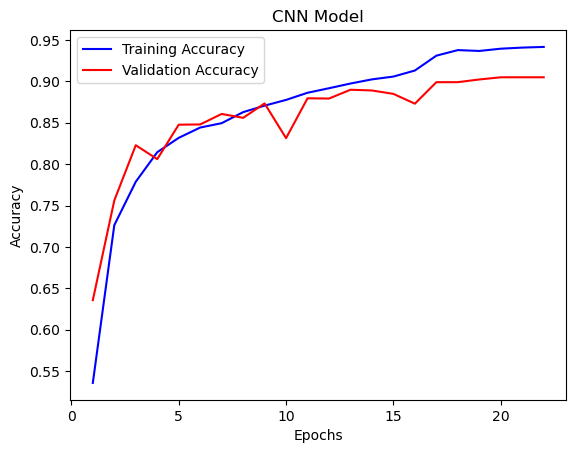

In [127]:
train_acc_cnn = training_history_cnn.history['accuracy']
val_acc_cnn = training_history_cnn.history['val_accuracy']

plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.plot(np.arange(1, 23, 1),
         train_acc_cnn,
         label = 'Training Accuracy',
         color = 'blue')

plt.plot(np.arange(1, 23, 1),
         val_acc_cnn,
         label = 'Validation Accuracy',
         color = 'red')

plt.title('CNN Model')
plt.legend()
plt.show()

In [128]:
test_pred_cnn = cnn.predict(X_test)
test_pred_class_cnn = test_pred_cnn.argmax(axis = 1)
cnn_accuracy = accuracy_score(y_test, test_pred_class_cnn)
print(cnn_accuracy)
print(metrics.classification_report(y_test, test_pred_class_cnn))

133/133 ━━━━━━━━━━━━━━━━━━━━ 13s 97ms/step
0.8979447200566973
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      2056
           1       0.85      0.85      0.85      1191
           2       0.96      0.94      0.95       293
           3       0.92      0.93      0.92       693

    accuracy                           0.90      4233
   macro avg       0.91      0.91      0.91      4233
weighted avg       0.90      0.90      0.90      4233



In [137]:
cnn.save("../data/ckpt/cnn_model_wholeimages2.h5")

In [140]:
keras.saving.save_model(cnn, '../data/ckpt/my_model.keras')

In [11]:
# training on downgraded tf version for GradCAM

training_history_cnn = cnn.fit(X_train, y_train, epochs = 25, batch_size = 64, validation_split = 0.2,
                               callbacks = [early_stopping, reduce_learning_rate],
                               class_weight = cw, verbose = True)

Epoch 1/25


2024-07-22 15:27:19.668263: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


212/212 [==============================] - 215s 1s/step - loss: 0.9381 - accuracy: 0.5593 - val_loss: 0.6550 - val_accuracy: 0.7393 - lr: 0.0010
Epoch 2/25
212/212 [==============================] - 220s 1s/step - loss: 0.5647 - accuracy: 0.7454 - val_loss: 0.7161 - val_accuracy: 0.7349 - lr: 0.0010
Epoch 3/25
212/212 [==============================] - 205s 968ms/step - loss: 0.4718 - accuracy: 0.7860 - val_loss: 0.4485 - val_accuracy: 0.8291 - lr: 0.0010
Epoch 4/25
212/212 [==============================] - 188s 884ms/step - loss: 0.4097 - accuracy: 0.8127 - val_loss: 0.4470 - val_accuracy: 0.8285 - lr: 0.0010
Epoch 5/25
212/212 [==============================] - 181s 851ms/step - loss: 0.3647 - accuracy: 0.8315 - val_loss: 0.4233 - val_accuracy: 0.8403 - lr: 0.0010
Epoch 6/25
212/212 [==============================] - 184s 866ms/step - loss: 0.3374 - accuracy: 0.8428 - val_loss: 0.3862 - val_accuracy: 0.8562 - lr: 0.0010
Epoch 7/25
212/212 [==============================] - 189s 893m

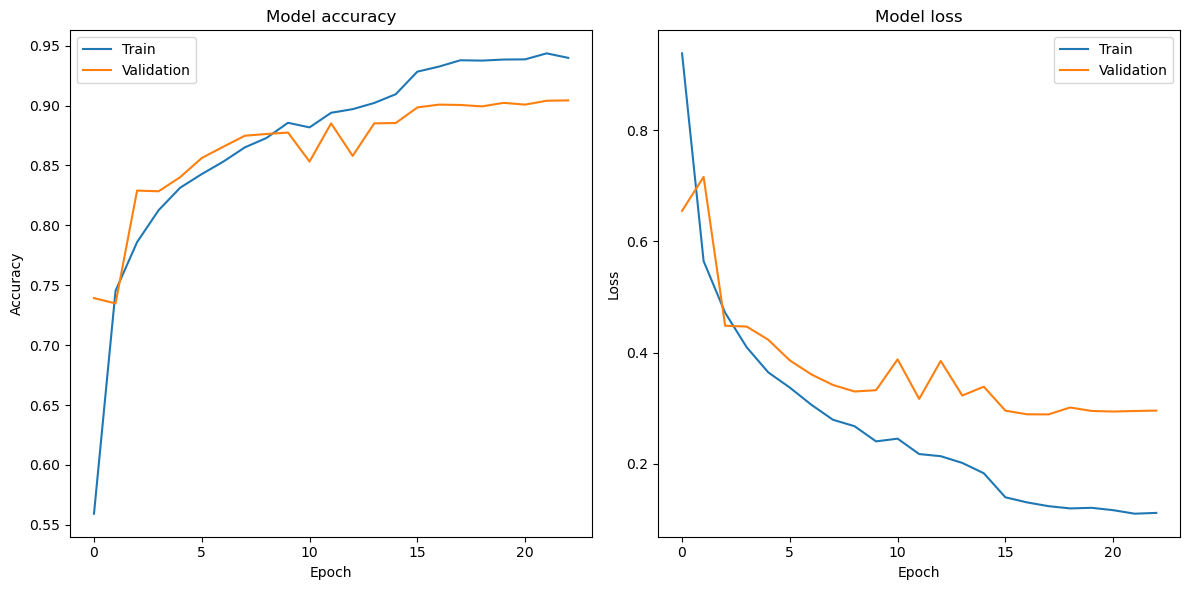

In [12]:
train_acc_cnn = training_history_cnn.history['accuracy']
val_acc_cnn = training_history_cnn.history['val_accuracy']

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(training_history_cnn.history['accuracy'])
plt.plot(training_history_cnn.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(training_history_cnn.history['loss'])
plt.plot(training_history_cnn.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [13]:
test_pred_cnn = cnn.predict(X_test)
test_pred_class_cnn = test_pred_cnn.argmax(axis = 1)
cnn_accuracy = accuracy_score(y_test, test_pred_class_cnn)
print(cnn_accuracy)
print(metrics.classification_report(y_test, test_pred_class_cnn))

133/133 [==============================] - 14s 105ms/step
0.9102291519017246
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      2056
           1       0.87      0.87      0.87      1191
           2       0.96      0.96      0.96       293
           3       0.93      0.94      0.93       693

    accuracy                           0.91      4233
   macro avg       0.92      0.92      0.92      4233
weighted avg       0.91      0.91      0.91      4233



In [14]:
cnn.save("../data/ckpt/cnn_model_wholeimages_tf2_12.h5")
cnn.save("../data/ckpt/cnn_model_wholeimages_tf2_12.keras")

In [28]:
train_dataset = train_datagen.flow(X_train, y_train, batch_size = 32)

test_dataset = test_datagen.flow(X_test, y_test, batch_size = 32)

batch_size = 32
training_history_cnn = cnn.fit(train_dataset, validation_data = test_dataset, epochs = 25, 
                                    callbacks = [early_stopping, reduce_learning_rate],
                                    class_weight = cw,
                                    verbose = True)

Epoch 1/25


/Users/philipptrinh/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


530/530 ━━━━━━━━━━━━━━━━━━━━ 372s 697ms/step - accuracy: 0.4555 - loss: 1.1622 - val_accuracy: 0.6813 - val_loss: 0.8000 - learning_rate: 0.0010
Epoch 2/25
530/530 ━━━━━━━━━━━━━━━━━━━━ 449s 842ms/step - accuracy: 0.6271 - loss: 0.7985 - val_accuracy: 0.7290 - val_loss: 0.6953 - learning_rate: 0.0010
Epoch 3/25
530/530 ━━━━━━━━━━━━━━━━━━━━ 554s 1s/step - accuracy: 0.6808 - loss: 0.6863 - val_accuracy: 0.7309 - val_loss: 0.6787 - learning_rate: 0.0010
Epoch 4/25
530/530 ━━━━━━━━━━━━━━━━━━━━ 506s 949ms/step - accuracy: 0.7059 - loss: 0.6393 - val_accuracy: 0.8018 - val_loss: 0.5441 - learning_rate: 0.0010
Epoch 5/25
530/530 ━━━━━━━━━━━━━━━━━━━━ 494s 926ms/step - accuracy: 0.7292 - loss: 0.5820 - val_accuracy: 0.8197 - val_loss: 0.5133 - learning_rate: 0.0010
Epoch 6/25
530/530 ━━━━━━━━━━━━━━━━━━━━ 422s 790ms/step - accuracy: 0.7449 - loss: 0.5421 - val_accuracy: 0.8280 - val_loss: 0.4685 - learning_rate: 0.0010
Epoch 7/25
530/530 ━━━━━━━━━━━━━━━━━━━━ 345s 643ms/step - accuracy: 0.7665 - l

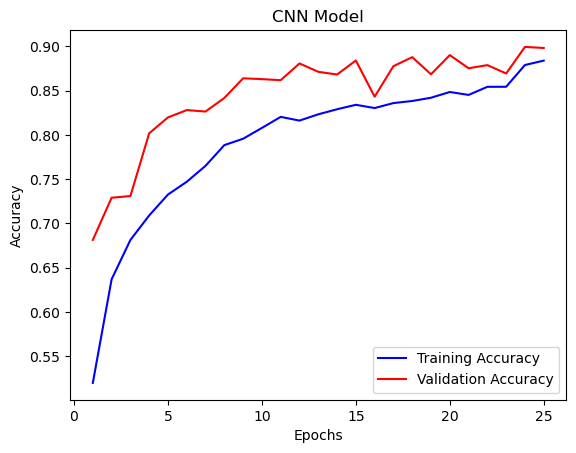

In [30]:
train_acc_cnn = training_history_cnn.history['accuracy']
val_acc_cnn = training_history_cnn.history['val_accuracy']

plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.plot(np.arange(1, 26, 1),
         train_acc_cnn,
         label = 'Training Accuracy',
         color = 'blue')

plt.plot(np.arange(1, 26, 1),
         val_acc_cnn,
         label = 'Validation Accuracy',
         color = 'red')

plt.title('CNN Model')
plt.legend()
plt.show()

In [31]:
test_pred_cnn = cnn.predict(X_test)
test_pred_class_cnn = test_pred_cnn.argmax(axis = 1)
cnn_accuracy = accuracy_score(y_test, test_pred_class_cnn)
print(cnn_accuracy)
print(metrics.classification_report(y_test, test_pred_class_cnn))

133/133 ━━━━━━━━━━━━━━━━━━━━ 14s 103ms/step
0.8981809591306402
              precision    recall  f1-score   support

           0       0.92      0.89      0.90      2056
           1       0.83      0.88      0.85      1191
           2       0.93      0.95      0.94       293
           3       0.94      0.94      0.94       693

    accuracy                           0.90      4233
   macro avg       0.90      0.92      0.91      4233
weighted avg       0.90      0.90      0.90      4233



In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
test_datagen = ImageDataGenerator()

In [18]:
# with tensorflow 2.12

train_dataset = train_datagen.flow(X_train, y_train, batch_size = 32)

test_dataset = test_datagen.flow(X_test, y_test, batch_size = 32)

batch_size = 32
training_history_cnn = cnn.fit(train_dataset, validation_data = test_dataset, epochs = 50, 
                                    callbacks = [early_stopping, reduce_learning_rate],
                                    class_weight = cw,
                                    verbose = True)

Epoch 1/50
530/530 [==============================] - 317s 591ms/step - loss: 0.9926 - accuracy: 0.5210 - val_loss: 0.7491 - val_accuracy: 0.6804 - lr: 0.0010
Epoch 2/50
530/530 [==============================] - 438s 822ms/step - loss: 0.7663 - accuracy: 0.6396 - val_loss: 0.6747 - val_accuracy: 0.7163 - lr: 0.0010
Epoch 3/50
530/530 [==============================] - 476s 895ms/step - loss: 0.6848 - accuracy: 0.6836 - val_loss: 0.6240 - val_accuracy: 0.7503 - lr: 0.0010
Epoch 4/50
530/530 [==============================] - 516s 971ms/step - loss: 0.6283 - accuracy: 0.7111 - val_loss: 0.5495 - val_accuracy: 0.7874 - lr: 0.0010
Epoch 5/50
530/530 [==============================] - 373s 702ms/step - loss: 0.5858 - accuracy: 0.7294 - val_loss: 0.5049 - val_accuracy: 0.8183 - lr: 0.0010
Epoch 6/50
530/530 [==============================] - 459s 863ms/step - loss: 0.5387 - accuracy: 0.7507 - val_loss: 0.5147 - val_accuracy: 0.8101 - lr: 0.0010
Epoch 7/50
530/530 [==========================

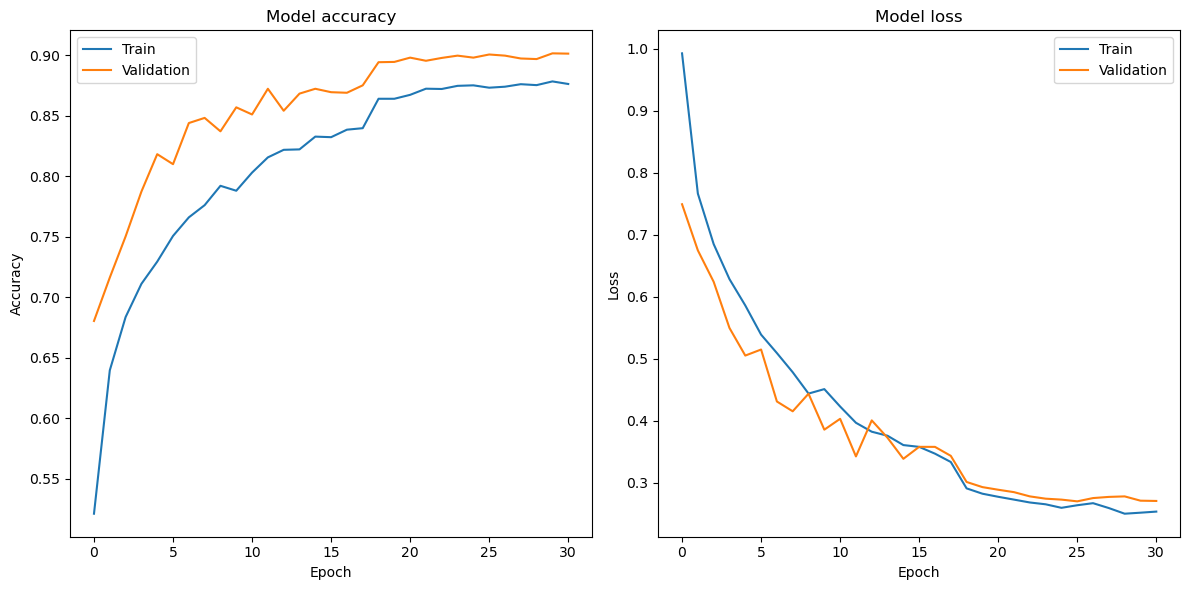

In [19]:
train_acc_cnn = training_history_cnn.history['accuracy']
val_acc_cnn = training_history_cnn.history['val_accuracy']

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(training_history_cnn.history['accuracy'])
plt.plot(training_history_cnn.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(training_history_cnn.history['loss'])
plt.plot(training_history_cnn.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [20]:
test_pred_cnn = cnn.predict(X_test)
test_pred_class_cnn = test_pred_cnn.argmax(axis = 1)
cnn_accuracy = accuracy_score(y_test, test_pred_class_cnn)
print(cnn_accuracy)
print(metrics.classification_report(y_test, test_pred_class_cnn))

133/133 [==============================] - 15s 110ms/step
0.9014883061658399
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      2056
           1       0.85      0.87      0.86      1191
           2       0.93      0.97      0.95       293
           3       0.94      0.93      0.94       693

    accuracy                           0.90      4233
   macro avg       0.91      0.92      0.91      4233
weighted avg       0.90      0.90      0.90      4233



In [21]:
cnn.save("../data/ckpt/cnn_model_wholeimages_augm_tf2_12.h5")
cnn.save("../data/ckpt/cnn_model_wholeimages_augm_tf2_12.keras")

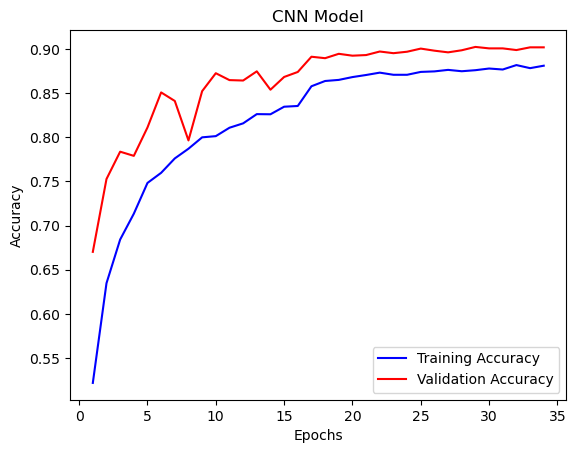

In [13]:
train_acc_cnn = training_history_cnn.history['accuracy']
val_acc_cnn = training_history_cnn.history['val_accuracy']

plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.plot(np.arange(1, 35, 1),
         train_acc_cnn,
         label = 'Training Accuracy',
         color = 'blue')

plt.plot(np.arange(1, 35, 1),
         val_acc_cnn,
         label = 'Validation Accuracy',
         color = 'red')

plt.title('CNN Model')
plt.legend()
plt.show()

In [14]:
test_pred_cnn = cnn.predict(X_test)
test_pred_class_cnn = test_pred_cnn.argmax(axis = 1)
cnn_accuracy = accuracy_score(y_test, test_pred_class_cnn)
print(cnn_accuracy)
print(metrics.classification_report(y_test, test_pred_class_cnn))

133/133 ━━━━━━━━━━━━━━━━━━━━ 14s 104ms/step
0.9017245452397826
              precision    recall  f1-score   support

           0       0.93      0.89      0.91      2056
           1       0.84      0.88      0.86      1191
           2       0.92      0.97      0.94       293
           3       0.94      0.93      0.93       693

    accuracy                           0.90      4233
   macro avg       0.91      0.92      0.91      4233
weighted avg       0.90      0.90      0.90      4233



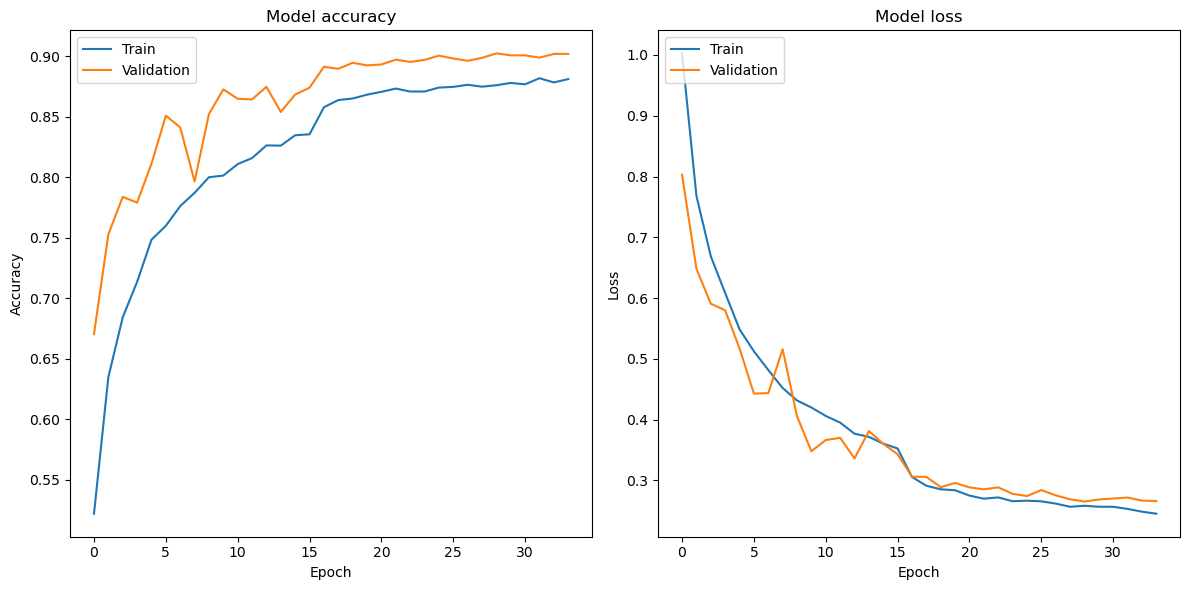

In [ ]:
train_acc_cnn = training_history_cnn.history['accuracy']
val_acc_cnn = training_history_cnn.history['val_accuracy']

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(training_history_cnn.history['accuracy'])
plt.plot(training_history_cnn.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(training_history_cnn.history['loss'])
plt.plot(training_history_cnn.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [17]:
cnn.save("../data/ckpt/cnn_model_wholeimages_augm.h5")
cnn.save("../data/ckpt/cnn_model_wholeimages_augm.keras")

In [32]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

early_stopping = EarlyStopping(monitor = 'val_loss', 
                               patience = 5, 
                               mode = 'min', 
                               verbose = 1)

reduce_learning_rate = ReduceLROnPlateau(monitor = 'val_loss', 
                                         patience = 3, 
                                         factor = 0.5,
                                         min_lr = 0.000001,
                                         cooldown = 4, 
                                         verbose = 1)

In [33]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
test_datagen = ImageDataGenerator()

In [34]:
train_dataset = train_datagen.flow(X_train, y_train, batch_size = 16)

test_dataset = test_datagen.flow(X_test, y_test, batch_size = 16)

batch_size = 16
training_history_cnn = cnn.fit(train_dataset, validation_data = test_dataset, epochs = 100, 
                                    callbacks = [early_stopping, reduce_learning_rate],
                                    class_weight = cw,
                                    verbose = True)

Epoch 1/100
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 231s 217ms/step - accuracy: 0.4803 - loss: 1.1576 - val_accuracy: 0.6693 - val_loss: 0.8063 - learning_rate: 0.0010
Epoch 2/100
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 254s 239ms/step - accuracy: 0.6270 - loss: 0.7896 - val_accuracy: 0.7172 - val_loss: 0.7461 - learning_rate: 0.0010
Epoch 3/100
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 248s 233ms/step - accuracy: 0.6842 - loss: 0.6798 - val_accuracy: 0.7838 - val_loss: 0.5935 - learning_rate: 0.0010
Epoch 4/100
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 231s 217ms/step - accuracy: 0.7049 - loss: 0.6304 - val_accuracy: 0.8030 - val_loss: 0.5366 - learning_rate: 0.0010
Epoch 5/100
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 228s 214ms/step - accuracy: 0.7428 - loss: 0.5637 - val_accuracy: 0.8195 - val_loss: 0.4721 - learning_rate: 0.0010
Epoch 6/100
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 233s 219ms/step - accuracy: 0.7605 - loss: 0.5463 - val_accuracy: 0.8377 - val_loss: 0.4658 - learning_rate: 0.0010
Epoch 7/100
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 231

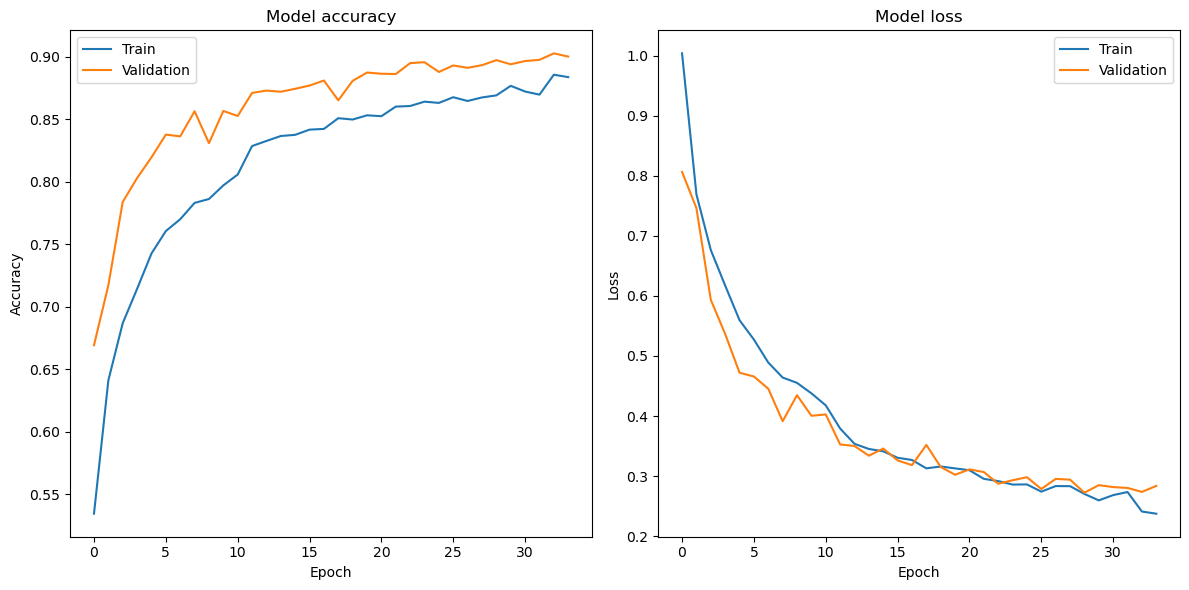

In [35]:
train_acc_cnn = training_history_cnn.history['accuracy']
val_acc_cnn = training_history_cnn.history['val_accuracy']

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(training_history_cnn.history['accuracy'])
plt.plot(training_history_cnn.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(training_history_cnn.history['loss'])
plt.plot(training_history_cnn.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [36]:
test_pred_cnn = cnn.predict(X_test)
test_pred_class_cnn = test_pred_cnn.argmax(axis = 1)
cnn_accuracy = accuracy_score(y_test, test_pred_class_cnn)
print(cnn_accuracy)
print(metrics.classification_report(y_test, test_pred_class_cnn))

133/133 ━━━━━━━━━━━━━━━━━━━━ 13s 99ms/step
0.9000708717221828
              precision    recall  f1-score   support

           0       0.93      0.89      0.91      2056
           1       0.82      0.90      0.86      1191
           2       0.95      0.95      0.95       293
           3       0.96      0.92      0.94       693

    accuracy                           0.90      4233
   macro avg       0.91      0.91      0.91      4233
weighted avg       0.90      0.90      0.90      4233



In [7]:
model = load_model('../data/ckpt/cnn_model_wholeimages_augm.keras')

/Users/philipptrinh/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 18 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [8]:
test_pred_model = model.predict(X_test)
test_pred_class_model = test_pred_model.argmax(axis = 1)
model_accuracy = accuracy_score(y_test, test_pred_class_model)
print(model_accuracy)
print(metrics.classification_report(y_test, test_pred_class_model))

133/133 ━━━━━━━━━━━━━━━━━━━━ 15s 108ms/step
0.9017245452397826
              precision    recall  f1-score   support

           0       0.93      0.89      0.91      2056
           1       0.84      0.88      0.86      1191
           2       0.92      0.97      0.94       293
           3       0.94      0.93      0.93       693

    accuracy                           0.90      4233
   macro avg       0.91      0.92      0.91      4233
weighted avg       0.90      0.90      0.90      4233



In [10]:
model.layers

[<Conv2D name=conv2d, built=True>,
 <MaxPooling2D name=max_pooling2d, built=True>,
 <Conv2D name=conv2d_1, built=True>,
 <MaxPooling2D name=max_pooling2d_1, built=True>,
 <Conv2D name=conv2d_2, built=True>,
 <MaxPooling2D name=max_pooling2d_2, built=True>,
 <Conv2D name=conv2d_3, built=True>,
 <MaxPooling2D name=max_pooling2d_3, built=True>,
 <Conv2D name=conv2d_4, built=True>,
 <MaxPooling2D name=max_pooling2d_4, built=True>,
 <Dropout name=dropout, built=True>,
 <Flatten name=flatten, built=True>,
 <Dense name=dense, built=True>,
 <Dropout name=dropout_1, built=True>,
 <Dense name=dense_1, built=True>,
 <Dropout name=dropout_2, built=True>,
 <Dense name=dense_2, built=True>]

In [9]:
for layer in model.layers:
    print(layer.name, layer.output_shape)

AttributeError: 'Conv2D' object has no attribute 'output_shape'

In [11]:
import tensorflow as tf

last_conv_layer_name = 'conv2d_4'  # Replace with the actual name of your last conv layer
last_conv_layer = model.get_layer(last_conv_layer_name)

grad_model = tf.keras.models.Model(
    [model.inputs],
    [last_conv_layer.output, model.output]
)

ValueError: The layer sequential has never been called and thus has no defined output.

### Building VGG16 pre-trained model

In [13]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(weights = 'imagenet', include_top = False)

for layer in base_model.layers:
    layer.trainable = False

n_class = 4

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D()) 
model.add(Dense(1024,activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(n_class, activation='softmax'))

In [27]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [14]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

early_stopping = EarlyStopping(monitor = 'val_loss', 
                               patience = 5, 
                               mode = 'min', 
                               verbose = 1)

reduce_learning_rate = ReduceLROnPlateau(monitor = 'val_loss', 
                                         patience = 3, 
                                         factor = 0.1,
                                         min_delta = 0.01,
                                         min_lr = 0.000001,
                                         cooldown = 4, 
                                         verbose = 1)

In [15]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input

train_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input,
                                          rotation_range = 10,
                                          width_shift_range = 0.1,
                                          height_shift_range = 0.1,
                                          zoom_range = 1.1,
                                          horizontal_flip = True)

test_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)

In [ ]:
# Load the dataframe
raw_lung_data = load('../data/raw_lung_data.joblib')

for row in raw_lung_data:
    print(row)

In [ ]:
# creating directories for flow_from_directory method

from shutil import copyfile

output_dir = '..data/imggen/dataset'

# Load the dataframe
raw_lung_data = load('../data/raw_lung_data.joblib')

for i in range(len(raw_lung_data)):
    raw_lung_data.at[i, 'filepath'] = os.path.join('..data/', raw_lung_data.at[i, 'name'])

# Create class subdirectories
for class_label in raw_lung_data['label'].unique():
    class_dir = os.path.join(output_dir, class_label)
    os.makedirs(class_dir, exist_ok=True)

# Move images to respective subdirectories
for index, row in raw_lung_data.iterrows():
    src_path = row['name']  # Adjust this based on your dataframe
    dst_path = os.path.join(output_dir, row['label'], os.path.basename(src_path))
    copyfile(src_path, dst_path)

# Now you can use flow_from_directory with output_dir as the dataset path


In [16]:
def convert_to_rgb(images):
    # Check if the input image has only one channel
    if images.shape[-1] == 1:
        images = np.concatenate([images] * 3, axis=-1)
    return images

# Example usage
X_train_rgb = convert_to_rgb(X_train)

In [17]:
print(X_train_rgb.shape)  # Should output (number_of_images, 256, 256, 3)

(16932, 256, 256, 3)


In [15]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


In [18]:
training_history_vgg16 = model.fit(X_train_rgb, y_train, epochs = 5, batch_size = 64, validation_split = 0.2,
                                   callbacks = [early_stopping, reduce_learning_rate],
                                   class_weight = cw, verbose = True)

Epoch 1/5
212/212 ━━━━━━━━━━━━━━━━━━━━ 1491s 7s/step - acc: 0.3775 - loss: 1.4700 - val_acc: 0.6177 - val_loss: 0.8564 - learning_rate: 0.0010
Epoch 2/5
212/212 ━━━━━━━━━━━━━━━━━━━━ 1483s 7s/step - acc: 0.6509 - loss: 0.9628 - val_acc: 0.7378 - val_loss: 0.6552 - learning_rate: 0.0010
Epoch 3/5
212/212 ━━━━━━━━━━━━━━━━━━━━ 1508s 7s/step - acc: 0.7026 - loss: 0.8690 - val_acc: 0.7694 - val_loss: 0.6037 - learning_rate: 0.0010
Epoch 4/5
212/212 ━━━━━━━━━━━━━━━━━━━━ 1483s 7s/step - acc: 0.7308 - loss: 0.7923 - val_acc: 0.7854 - val_loss: 0.5522 - learning_rate: 0.0010
Epoch 5/5
212/212 ━━━━━━━━━━━━━━━━━━━━ 1494s 7s/step - acc: 0.7211 - loss: 0.7830 - val_acc: 0.6738 - val_loss: 0.7221 - learning_rate: 0.0010


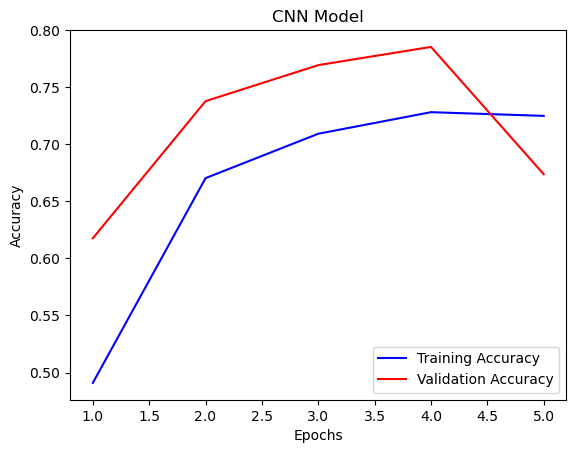

In [23]:
train_acc_vgg16 = training_history_vgg16.history['acc']
val_acc_vgg16 = training_history_vgg16.history['val_acc']

plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.plot(np.arange(1, 6, 1),
         train_acc_vgg16,
         label = 'Training Accuracy',
         color = 'blue')

plt.plot(np.arange(1, 6, 1),
         val_acc_vgg16,
         label = 'Validation Accuracy',
         color = 'red')

plt.title('CNN Model')
plt.legend()
plt.show()

In [21]:
# Example usage
X_test_rgb = convert_to_rgb(X_test)

In [22]:
test_pred_vgg16 = model.predict(X_test_rgb)
test_pred_class_vgg16 = test_pred_vgg16.argmax(axis = 1)
vgg16_accuracy = accuracy_score(y_test, test_pred_class_vgg16)
print(vgg16_accuracy)
print(metrics.classification_report(y_test, test_pred_class_vgg16))

133/133 ━━━━━━━━━━━━━━━━━━━━ 376s 3s/step
0.6756437514764942
              precision    recall  f1-score   support

           0       0.95      0.63      0.76      2056
           1       0.93      0.52      0.67      1185
           2       0.78      0.90      0.84       262
           3       0.37      0.96      0.53       730

    accuracy                           0.68      4233
   macro avg       0.76      0.75      0.70      4233
weighted avg       0.83      0.68      0.70      4233



### Building another CNN model with dropout layers

In [108]:
img_width = 256
img_height = 256

cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Dropout(rate=0.2))
cnn.add(Flatten())
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dropout(rate=0.2))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'softmax', units = 4))

/Users/philipptrinh/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [109]:
cnn.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_50 (Conv2D)              │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 125, 125, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_51 (MaxPooling2D) │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 60, 60, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_52 (MaxPooling2D) │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_53 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_54 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 377,796 (1.44 MB)

 Trainable params: 377,796 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

In [110]:
cnn.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [112]:
training_history_cnn = cnn.fit(X_train, y_train, epochs = 25, batch_size = 64, validation_split = 0.2,
                                   callbacks = [early_stopping, reduce_learning_rate],
                                   class_weight = cw, verbose = True)

# early stopping min val_loss, cpu

Epoch 1/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 135s 626ms/step - accuracy: 0.2881 - loss: 1.5200 - val_accuracy: 0.5371 - val_loss: 0.9978 - learning_rate: 0.0010
Epoch 2/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 136s 642ms/step - accuracy: 0.6053 - loss: 1.0461 - val_accuracy: 0.6794 - val_loss: 0.7010 - learning_rate: 0.0010
Epoch 3/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 141s 666ms/step - accuracy: 0.6833 - loss: 0.8759 - val_accuracy: 0.7417 - val_loss: 0.6407 - learning_rate: 0.0010
Epoch 4/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 133s 627ms/step - accuracy: 0.7313 - loss: 0.7684 - val_accuracy: 0.7606 - val_loss: 0.5807 - learning_rate: 0.0010
Epoch 5/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 130s 611ms/step - accuracy: 0.7454 - loss: 0.7062 - val_accuracy: 0.7390 - val_loss: 0.6226 - learning_rate: 0.0010
Epoch 6/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 128s 601ms/step - accuracy: 0.7630 - loss: 0.6688 - val_accuracy: 0.7721 - val_loss: 0.5605 - learning_rate: 0.0010
Epoch 7/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 132s 623ms/step - accura

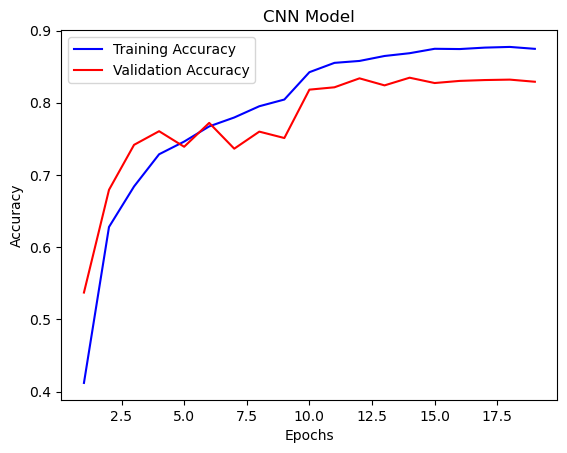

In [116]:
train_acc_cnn = training_history_cnn.history['accuracy']
val_acc_cnn = training_history_cnn.history['val_accuracy']

plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.plot(np.arange(1, 20, 1),
         train_acc_cnn,
         label = 'Training Accuracy',
         color = 'blue')

plt.plot(np.arange(1, 20, 1),
         val_acc_cnn,
         label = 'Validation Accuracy',
         color = 'red')

plt.title('CNN Model')
plt.legend()
plt.show()

In [117]:
test_pred_cnn = cnn.predict(X_test)
test_pred_class_cnn = test_pred_cnn.argmax(axis = 1)
cnn_accuracy = accuracy_score(y_test, test_pred_class_cnn)
print(cnn_accuracy)
print(metrics.classification_report(y_test, test_pred_class_cnn))

133/133 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step
0.8353413654618473
              precision    recall  f1-score   support

           0       0.93      0.83      0.88      2056
           1       0.83      0.82      0.83      1185
           2       0.91      0.89      0.90       262
           3       0.64      0.86      0.73       730

    accuracy                           0.84      4233
   macro avg       0.83      0.85      0.83      4233
weighted avg       0.85      0.84      0.84      4233

